In [79]:
#pip install "pandas<2.0.0"
#!pip install swifter
#!pip install tensorflow

In [24]:
#Environnement

import pandas as pd
import joblib
from joblib import load,dump
import numpy as np
import matplotlib.pyplot as plt


import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout


In [73]:
#Dépendances
#fonction pour gestion de la ponctuation et des balises avant suppression
def remplacement_encodage(text):
    #gestion des caractères mal encodés hors html
    text = text.replace("à¢","â")
    text = text.replace("â¿¿","'")
    text = text.replace("Â°","°")
    text = text.replace("¿","oe")
    #suppression encodage html
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    return text

# Converts the unicode file to ascii 
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    stop_words = stopwords.words('french')
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

def preprocess_texte(df,maxlen=500,num_words=10000,embedding_dim = 200,langue= "FR"):
    
    if langue == 'FR':
        df.texte_traduit_fr = df.texte_traduit_fr.swifter.apply(remplacement_encodage)
        df.texte_traduit_fr = df.texte_traduit_fr.swifter.apply(lambda x :preprocess_sentence(x))
        #Encodage cible
        le = LabelEncoder()
        le.fit(df.prdtypecode)
        target = le.transform(df.prdtypecode)

        X_text_train, X_text_test, y_train, y_test = train_test_split(df.texte_traduit_fr, target, test_size=0.2, random_state=1234)

        # Définition du tokenizer
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
        # Mettre à jour le dictionnaire du tokenizer
        tokenizer.fit_on_texts(X_text_train)

        word2idx = tokenizer.word_index
        idx2word = tokenizer.index_word
        vocab_size = tokenizer.num_words

        #transformation du texte en sequences d'index
        X_train = tokenizer.texts_to_sequences(X_text_train)
        X_test = tokenizer.texts_to_sequences(X_text_test)

        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
    
    if langue == 'EN':
        df.texte_traduit_en = df.texte_traduit_en.swifter.apply(remplacement_encodage)
        df.texte_traduit_en = df.texte_traduit_en.swifter.apply(lambda x :preprocess_sentence(x))
        #Encodage cible
        le = LabelEncoder()
        le.fit(df.prdtypecode)
        target = le.transform(df.prdtypecode)

        X_text_train, X_text_test, y_train, y_test = train_test_split(df.texte_traduit_en, target, test_size=0.2, random_state=1234)

        # Définition du tokenizer
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
        # Mettre à jour le dictionnaire du tokenizer
        tokenizer.fit_on_texts(X_text_train)

        word2idx = tokenizer.word_index
        idx2word = tokenizer.index_word
        vocab_size = tokenizer.num_words

        #transformation du texte en sequences d'index
        X_train = tokenizer.texts_to_sequences(X_text_train)
        X_test = tokenizer.texts_to_sequences(X_text_test)

        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')  
        
        
        
    return X_train, X_test, y_train, y_test        
                           
def train_model(X_train, X_test,y_train,y_test,num_words=10000,embedding_dim = 200):
    #Construction du modèle 
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim))
    model.add(RNN(GRUCell(128), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))     
    model.add(Dropout(0.3))
    model.add(Dense(27, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
    batch_size = 64,
    epochs=6,
    callbacks=[[reduce_learning_rate, early_stopping]],
    validation_data = [X_test, y_test])
    return model    
               

In [26]:
#Définition des CallBacks

from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(monitor="val_loss",
                               min_delta = 0.01,
                               patience = 2,
                               verbose=1,
                               restore_best_weights = True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss",
                                         patience = 2,
                                         factor = 0.1,
                                         cooldown = 3,
                                         verbose=1,
                                         min_lr = 1e-6)

model_checkpoint = ModelCheckpoint(filepath = get_output_path_folder("Fichiers_points_de_controles"),
                                    monitor = "val_loss",
                                    verbose = 1,
                                    save_best_only = False,
                                    save_weights_only= False,
                                    moder = "auto",
                                    save_freq="epoch")

# Données

In [ ]:
df = load("df_translated.joblib")

df.description = df.description.astype("str")
df.description_fr = df.description_fr.astype("str")
df.description_en = df.description_en.astype("str")

# fusion de désignation et description
df["texte_non_traduit"] = df.apply(lambda row: row["designation"] + " " + row["description"] if ((row["description"]!='nan') and (row["designation"] != row["description"])) else row["designation"], axis=1)

df["texte_traduit_fr"] = df.apply(lambda row: row["designation_fr"] + " " + row["description_fr"] if ((row["description_fr"]!='nan') and (row["designation_fr"] != row["description_fr"])) else row["designation_fr"], axis=1)

df["texte_traduit_en"] = df.apply(lambda row: row["designation_en"] + " " + row["description_en"] if ((row["description_en"]!='nan') and (row["designation_en"] != row["description_en"])) else row["designation_en"], axis=1)

#retrait des colonnes initiales description et designation
to_drop=['description','designation','productid', 'imageid','langues détectées', 'designation_fr', 'designation_en',
       'description_fr', 'description_en']
df = df.drop(columns = to_drop)
df_texte_non_traduit = df.drop(columns =['texte_traduit_fr', 'texte_traduit_en'])
df_texte_traduit_fr = df.drop(columns =['texte_non_traduit', 'texte_traduit_en'])
df_texte_traduit_en = df.drop(columns =['texte_non_traduit', 'texte_traduit_fr'])


#Enregistrement sauvegarde
dump(df_texte_non_traduit,"df_texte_non_traduit.joblib")
dump(df_texte_traduit_fr,"df_texte_traduit_fr.joblib")
dump(df_texte_traduit_en,"df_texte_traduit_en.joblib")

df_texte_non_traduit = load("df_texte_non_traduit.joblib")
df_texte_traduit_fr = load("df_texte_traduit_fr.joblib")
df_texte_traduit_en = load("df_texte_traduit_en.joblib")


# Travail à l'aide du texte traduit intégralement en FR

In [9]:
df = load('df_texte_traduit_fr.joblib')
df.head()

,prdtypecode,texte_traduit_fr
0,10,Olivia : Carnet personnalisé / 150 pages / Dot...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...


In [10]:
## Essai sur des paramètres fixes

In [12]:
X_train, X_test, y_train, y_test = preprocess_texte(df,maxlen=500,num_words=10000,embedding_dim = 200)

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

In [144]:
history = model.fit(X_train, y_train,
    batch_size = 64,
    epochs=10,
    validation_data = [X_test, y_test])


Epoch 1/10
1062/1062 [==============================] - 601s 564ms/step - loss: 1.6994 - accuracy: 0.4881 - val_loss: 0.9705 - val_accuracy: 0.7087
Epoch 2/10
1062/1062 [==============================] - 615s 579ms/step - loss: 0.8210 - accuracy: 0.7543 - val_loss: 0.8005 - val_accuracy: 0.7603
Epoch 3/10
1062/1062 [==============================] - 604s 568ms/step - loss: 0.6260 - accuracy: 0.8106 - val_loss: 0.7698 - val_accuracy: 0.7738
Epoch 4/10
1062/1062 [==============================] - 597s 562ms/step - loss: 0.5133 - accuracy: 0.8423 - val_loss: 0.7893 - val_accuracy: 0.7779
Epoch 5/10
1062/1062 [==============================] - 600s 565ms/step - loss: 0.4311 - accuracy: 0.8645 - val_loss: 0.8104 - val_accuracy: 0.7804
Epoch 6/10
1062/1062 [==============================] - 614s 578ms/step - loss: 0.3643 - accuracy: 0.8840 - val_loss: 0.8670 - val_accuracy: 0.7780
Epoch 7/10
1062/1062 [==============================] - 609s 574ms/step - loss: 0.3115 - accuracy: 0.8994 - val_

In [147]:
model.save("DL_texte_fred_v1")

INFO:tensorflow:Assets written to: DL_texte_fred_v1\assets


INFO:tensorflow:Assets written to: DL_texte_fred_v1\assets


### Optimisation du paramètre maxlen

In [19]:
scores_test_maxlen=[]

for maxlen in np.arange(100,1000,200):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=10000,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=10000,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=64)
    scores_test_maxlen.append(score)  

scores_test_maxlen = list(np.array(scores_test_maxlen)[:,1])

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4


1062/1062 [==============================] - 86s 79ms/step - loss: 1.4844 - accuracy: 0.5463 - val_loss: 0.9160 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 85s 80ms/step - loss: 0.7655 - accuracy: 0.7706 - val_loss: 0.7755 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 86s 81ms/step - loss: 0.5869 - accuracy: 0.8209 - val_loss: 0.7860 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 4/4
1061/1062 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.8505
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 85s 80ms/step - loss: 0.4838 - accuracy: 0.8505 - val_loss: 0.7981 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 4: early stopping
266/266 [==============================] - 6s 22ms/step - loss: 0.7755 - accuracy: 0.7640


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 246s 231ms/step - loss: 1.7022 - accuracy: 0.4793 - val_loss: 1.0162 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 243s 229ms/step - loss: 0.8533 - accuracy: 0.7430 - val_loss: 0.8187 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 250s 235ms/step - loss: 0.6527 - accuracy: 0.8015 - val_loss: 0.7710 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 4/4
266/266 [==============================] - 18s 68ms/step - loss: 0.8012 - accuracy: 0.7725


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 538s 505ms/step - loss: 1.7486 - accuracy: 0.4717 - val_loss: 0.9945 - val_accuracy: 0.6966 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 546s 514ms/step - loss: 0.8461 - accuracy: 0.7486 - val_loss: 0.8156 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 554s 522ms/step - loss: 0.6502 - accuracy: 0.8033 - val_loss: 0.7784 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 4/4
266/266 [==============================] - 37s 139ms/step - loss: 0.7966 - accuracy: 0.7746


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 833s 783ms/step - loss: 1.8053 - accuracy: 0.4521 - val_loss: 0.9922 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 920s 867ms/step - loss: 0.8413 - accuracy: 0.7497 - val_loss: 0.8143 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 933s 879ms/step - loss: 0.6363 - accuracy: 0.8086 - val_loss: 0.7746 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 4/4
266/266 [==============================] - 57s 213ms/step - loss: 0.8016 - accuracy: 0.7704


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 1512s 1s/step - loss: 1.8414 - accuracy: 0.4483 - val_loss: 1.0130 - val_accuracy: 0.6966 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 1470s 1s/step - loss: 0.8508 - accuracy: 0.7456 - val_loss: 0.7938 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 1527s 1s/step - loss: 0.6402 - accuracy: 0.8056 - val_loss: 0.7664 - val_accuracy: 0.7746 - lr: 0.0010
Epoch 4/4
266/266 [==============================] - 89s 333ms/step - loss: 0.7915 - accuracy: 0.7715


In [22]:
np.array(scores_test_maxlen)

array([0.76401317, 0.77249175, 0.77455252, 0.77043098, 0.77149081])

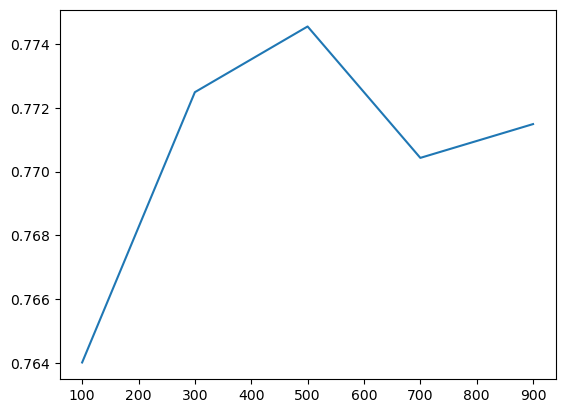

In [30]:
scores_test_maxlen_show = list(np.array(scores_test_maxlen)[:])

plt.plot(np.arange(100,1000,200),scores_test_maxlen_show)
plt.show();

In [31]:
#mise en Dataframe
scores_test_maxlen=np.array(scores_test_maxlen) 
datascores_maxlen=pd.DataFrame(scores_test_maxlen,columns=['score'])
datascores_maxlen['maxlen'] = np.arange(100,1000,200)
datascores_maxlen['num_words']=[10_000]*5
datascores_maxlen['embedding_dim']=[200]*5

In [32]:
datascores_maxlen.head()

,score,maxlen,num_words,embedding_dim
0,0.764013,100,10000,200
1,0.772492,300,10000,200
2,0.774553,500,10000,200
3,0.770431,700,10000,200
4,0.771491,900,10000,200


### Optimisation du paramètre num_words

#### partie 1

In [ ]:
scores_num_words=[]
maxlen = 300

for num_words in np.arange(1000,100000,9000):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_num_words.append(score)  


In [ ]:
scores_num_words_show= list(np.array(scores_num_words)[:,1])

plt.plot(np.arange(1000,100000,9000),scores_num_words_show)
plt.show()

print(max(scores_num_words))

In [ ]:
scores_num_words=np.array(scores_num_words)
datascores_num_words=pd.DataFrame(scores_num_words,columns=['score'])
data_scores_num_words['maxlen'] = [300]*11
data_scores_num_words['embedding_dim'] =[200]*11
data_scores_num_words['num_words']= np.arange(1000,100000,9000)

#### partie 2

In [ ]:
scores_num_words_2=[]
maxlen = 300

for num_words in np.arange(100000,200000,15000):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_num_words_3.append(score) 


In [ ]:
scores_num_words_2_show= list(np.array(scores_num_words_2)[:,1])

plt.plot(np.arange(100000,200000,15000),scores_num_words_2_show)
plt.show()

print(max(scores_num_words_2))

In [ ]:
scores_num_words_2=np.array(scores_num_words_2)
datascores_num_words_2=pd.DataFrame(scores_num_words_2,columns=['score'])
data_scores_num_words_2['maxlen'] = [300]*11
data_scores_num_words_2['embedding_dim'] =[200]*11
data_scores_num_words_2['num_words']= np.arange(100000,200000,15000)

### Optimisation du paramètre embedding_dim

In [ ]:
#Application
scores_embedding_dim=[]
maxlen = 300
num_words= 100000

for embedding_dim in np.arange(50,800,100):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_embedding_dim.append(score) 

In [ ]:
scores_embedding_dim_show= list(np.array(scores_embedding_dim)[:,1])

plt.plot(nnp.arange(50,800,100),scores_embedding_dim_show)
plt.show()

print(max(scores_embedding_dim))

In [ ]:
scores_embedding_dim=np.array(scores_embedding_dim) 
datascores_embedding_dim=pd.DataFrame(scores_embedding_dim,columns=column_names)
datascores_embedding_dim['maxlen'] = [300]*5
datascores_embedding_dim['num_words']=[100_000]*5
datascores_embedding_dim['embedding_dim']=np.arange(50,500,100)

# Enregistrement et chargement du df_score

In [ ]:
df = pd.concat([datascores_embedding_dim, data_scores_num_words,data_scores_num_words_2])
joblib.dump(df,'df_score_texte.joblib')

In [ ]:
# Chargement du fichier de score

In [47]:
import joblib
df = joblib.load ('df_score_texte.joblib')

In [48]:
df_scores_DL_texte = pd.concat([datascores_maxlen,df])

In [49]:
df_scores_DL_texte.head(55)

,score,maxlen,num_words,embedding_dim
0,0.764013,100,10000,200
1,0.772492,300,10000,200
2,0.774553,500,10000,200
3,0.770431,700,10000,200
4,0.771491,900,10000,200
0,0.781029,300,100000,50
1,0.779263,300,100000,150
2,0.788154,300,100000,250
3,0.778851,300,100000,350
4,0.788389,300,100000,450


In [50]:
# La modification des paramètres maxlen, num_words et embedding_dim ne permet pas d'améliorer sensiblement le score

In [53]:
df_etude_num_words =  df_scores_DL_texte[(df_scores_DL_texte['maxlen'].values == 300) & (df_scores_DL_texte['embedding_dim'].values == 100000)]

Text(0, 0.5, 'score')

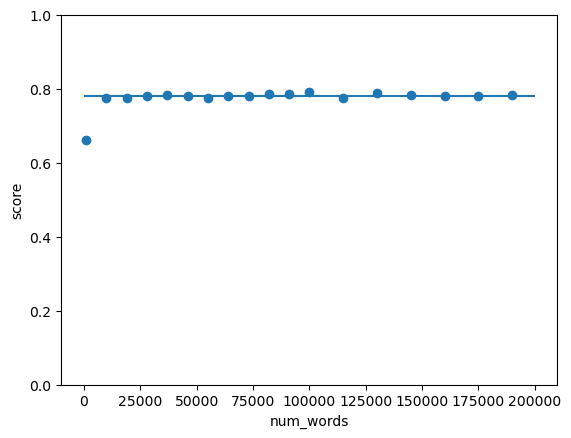

In [58]:
plt.scatter(df_etude_num_words.num_words, df_etude_num_words.score)
plt.ylim(0,1)
plt.hlines(0.78, 0,200000)
plt.xlabel('num_words')
plt.ylabel('score')

In [59]:
print("la variable numw_ords n'a pas d'effet significatif sur le score du modèle")

la variable numw_ords n'a pas d'effet significatif sur le score du modèle


ANNEXE : Essais lancés

In [24]:
#Application
scores_num_words=[]
maxlen = 300

for num_words in np.arange(1000,100000,9000):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_num_words.append(score)  


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 229s 215ms/step - loss: 1.9214 - accuracy: 0.4213 - val_loss: 1.3675 - val_accuracy: 0.5939 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 226s 213ms/step - loss: 1.2974 - accuracy: 0.6154 - val_loss: 1.1945 - val_accuracy: 0.6378 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 228s 214ms/step - loss: 1.1548 - accuracy: 0.6544 - val_loss: 1.1287 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 4/4
133/133 [==============================] - 14s 106ms/step - loss: 1.1074 - accuracy: 0.6627


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 263s 246ms/step - loss: 1.6694 - accuracy: 0.4959 - val_loss: 0.9541 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 263s 247ms/step - loss: 0.8111 - accuracy: 0.7587 - val_loss: 0.7993 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 262s 247ms/step - loss: 0.6211 - accuracy: 0.8127 - val_loss: 0.7478 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 4/4
133/133 [==============================] - 16s 120ms/step - loss: 0.7764 - accuracy: 0.7748


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 325s 304ms/step - loss: 1.6112 - accuracy: 0.5076 - val_loss: 0.9453 - val_accuracy: 0.7154 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 316s 298ms/step - loss: 0.7474 - accuracy: 0.7767 - val_loss: 0.7606 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 316s 298ms/step - loss: 0.5343 - accuracy: 0.8371 - val_loss: 0.7646 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8717
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 315s 297ms/step - loss: 0.4131 - accuracy: 0.8717 - val_loss: 0.8073 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 17s 130ms/step - loss: 0.7606 - accuracy: 0.7753


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 316s 297ms/step - loss: 1.5986 - accuracy: 0.5143 - val_loss: 0.9202 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 305s 287ms/step - loss: 0.7226 - accuracy: 0.7827 - val_loss: 0.7383 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 304s 286ms/step - loss: 0.4814 - accuracy: 0.8543 - val_loss: 0.7590 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8932
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 315s 296ms/step - loss: 0.3459 - accuracy: 0.8932 - val_loss: 0.8136 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 17s 131ms/step - loss: 0.7383 - accuracy: 0.7818


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 304s 285ms/step - loss: 1.6340 - accuracy: 0.5027 - val_loss: 0.9521 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 296s 279ms/step - loss: 0.7287 - accuracy: 0.7811 - val_loss: 0.7401 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 297s 279ms/step - loss: 0.4729 - accuracy: 0.8562 - val_loss: 0.7405 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8997
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 298s 280ms/step - loss: 0.3276 - accuracy: 0.8997 - val_loss: 0.8075 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 15s 111ms/step - loss: 0.7401 - accuracy: 0.7822


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 386s 362ms/step - loss: 1.7219 - accuracy: 0.4699 - val_loss: 0.9998 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 365s 344ms/step - loss: 0.7486 - accuracy: 0.7748 - val_loss: 0.7388 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 362s 341ms/step - loss: 0.4591 - accuracy: 0.8624 - val_loss: 0.7349 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - 362s 341ms/step - loss: 0.3079 - accuracy: 0.9051 - val_loss: 0.8290 - val_accuracy: 0.7909 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 18s 133ms/step - loss: 0.7388 - accuracy: 0.7809


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 343s 322ms/step - loss: 1.6215 - accuracy: 0.5051 - val_loss: 0.9078 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 335s 315ms/step - loss: 0.7123 - accuracy: 0.7861 - val_loss: 0.7503 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 332s 312ms/step - loss: 0.4421 - accuracy: 0.8656 - val_loss: 0.7500 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - 332s 312ms/step - loss: 0.2888 - accuracy: 0.9120 - val_loss: 0.8378 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 16s 117ms/step - loss: 0.7503 - accuracy: 0.7751


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 389s 365ms/step - loss: 1.6359 - accuracy: 0.4995 - val_loss: 0.9151 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 383s 361ms/step - loss: 0.6969 - accuracy: 0.7919 - val_loss: 0.7246 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 386s 363ms/step - loss: 0.4212 - accuracy: 0.8717 - val_loss: 0.7711 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9171
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 384s 362ms/step - loss: 0.2721 - accuracy: 0.9171 - val_loss: 0.8645 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 139ms/step - loss: 0.7246 - accuracy: 0.7805


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 394s 370ms/step - loss: 1.5892 - accuracy: 0.5159 - val_loss: 0.8779 - val_accuracy: 0.7352 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 380s 358ms/step - loss: 0.6750 - accuracy: 0.7983 - val_loss: 0.7431 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 382s 360ms/step - loss: 0.4106 - accuracy: 0.8735 - val_loss: 0.7824 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9185
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 381s 359ms/step - loss: 0.2657 - accuracy: 0.9185 - val_loss: 0.8851 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 18s 134ms/step - loss: 0.7431 - accuracy: 0.7806


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 382s 358ms/step - loss: 1.6217 - accuracy: 0.5075 - val_loss: 0.8976 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 378s 356ms/step - loss: 0.6743 - accuracy: 0.7974 - val_loss: 0.7204 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 378s 356ms/step - loss: 0.3821 - accuracy: 0.8841 - val_loss: 0.7588 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9308
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 379s 357ms/step - loss: 0.2307 - accuracy: 0.9308 - val_loss: 0.8760 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 16s 122ms/step - loss: 0.7204 - accuracy: 0.7853


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 430s 403ms/step - loss: 1.6712 - accuracy: 0.4846 - val_loss: 0.9446 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 419s 395ms/step - loss: 0.7072 - accuracy: 0.7852 - val_loss: 0.7325 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 421s 396ms/step - loss: 0.4136 - accuracy: 0.8747 - val_loss: 0.7558 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9220
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 421s 397ms/step - loss: 0.2540 - accuracy: 0.9220 - val_loss: 0.8960 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 18s 133ms/step - loss: 0.7325 - accuracy: 0.7853


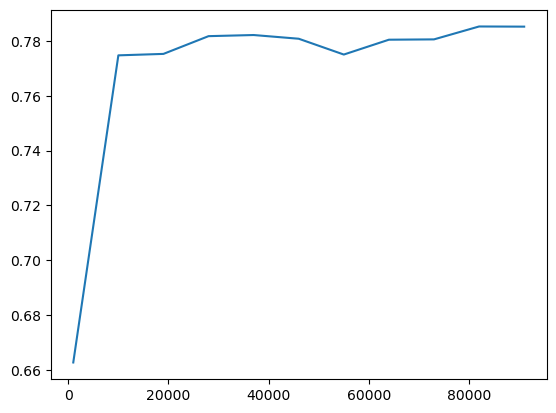

0.7853273749351501


In [33]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1000,100000,9000),scores_num_words_2)
plt.show()

print(max(scores_num_words_2))

In [34]:
scores_num_words_3=[]
maxlen = 300

for num_words in np.arange(100000,200000,15000):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_num_words_3.append(score)  


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 420s 394ms/step - loss: 1.6025 - accuracy: 0.5124 - val_loss: 0.8745 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 425s 400ms/step - loss: 0.6677 - accuracy: 0.8009 - val_loss: 0.7266 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 410s 386ms/step - loss: 0.3783 - accuracy: 0.8842 - val_loss: 0.7730 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9313
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 412s 388ms/step - loss: 0.2244 - accuracy: 0.9313 - val_loss: 0.9169 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 17s 126ms/step - loss: 0.7266 - accuracy: 0.7908


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 401s 376ms/step - loss: 1.5837 - accuracy: 0.5207 - val_loss: 0.8856 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 400s 376ms/step - loss: 0.6783 - accuracy: 0.7973 - val_loss: 0.7617 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 410s 386ms/step - loss: 0.3853 - accuracy: 0.8848 - val_loss: 0.8121 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9332
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 401s 378ms/step - loss: 0.2229 - accuracy: 0.9332 - val_loss: 0.9230 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 15s 114ms/step - loss: 0.7617 - accuracy: 0.7766


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 460s 431ms/step - loss: 1.6263 - accuracy: 0.5015 - val_loss: 0.9164 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 462s 435ms/step - loss: 0.6755 - accuracy: 0.7946 - val_loss: 0.7112 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 462s 435ms/step - loss: 0.3773 - accuracy: 0.8843 - val_loss: 0.7559 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9345
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 493s 465ms/step - loss: 0.2152 - accuracy: 0.9345 - val_loss: 0.8939 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 139ms/step - loss: 0.7112 - accuracy: 0.7900


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 466s 438ms/step - loss: 1.6452 - accuracy: 0.4958 - val_loss: 0.9634 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 464s 437ms/step - loss: 0.7036 - accuracy: 0.7873 - val_loss: 0.7335 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 465s 438ms/step - loss: 0.3860 - accuracy: 0.8831 - val_loss: 0.7862 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9321
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 462s 435ms/step - loss: 0.2232 - accuracy: 0.9321 - val_loss: 0.9474 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 16s 120ms/step - loss: 0.7335 - accuracy: 0.7836


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 478s 449ms/step - loss: 1.6653 - accuracy: 0.4887 - val_loss: 0.9400 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 491s 462ms/step - loss: 0.6980 - accuracy: 0.7914 - val_loss: 0.7506 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 492s 464ms/step - loss: 0.3894 - accuracy: 0.8828 - val_loss: 0.7811 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9303
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 477s 449ms/step - loss: 0.2286 - accuracy: 0.9303 - val_loss: 0.9064 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 16s 121ms/step - loss: 0.7506 - accuracy: 0.7817


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 559s 525ms/step - loss: 1.6323 - accuracy: 0.4976 - val_loss: 0.9146 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 569s 536ms/step - loss: 0.6973 - accuracy: 0.7909 - val_loss: 0.7487 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 554s 522ms/step - loss: 0.4014 - accuracy: 0.8788 - val_loss: 0.7868 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9284
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 561s 529ms/step - loss: 0.2398 - accuracy: 0.9284 - val_loss: 0.8955 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 21s 155ms/step - loss: 0.7487 - accuracy: 0.7800


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 575s 540ms/step - loss: 1.5868 - accuracy: 0.5168 - val_loss: 0.8591 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 557s 525ms/step - loss: 0.6421 - accuracy: 0.8079 - val_loss: 0.7378 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 574s 540ms/step - loss: 0.3536 - accuracy: 0.8925 - val_loss: 0.7914 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9376
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 575s 542ms/step - loss: 0.2053 - accuracy: 0.9376 - val_loss: 0.8983 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 16s 123ms/step - loss: 0.7378 - accuracy: 0.7836


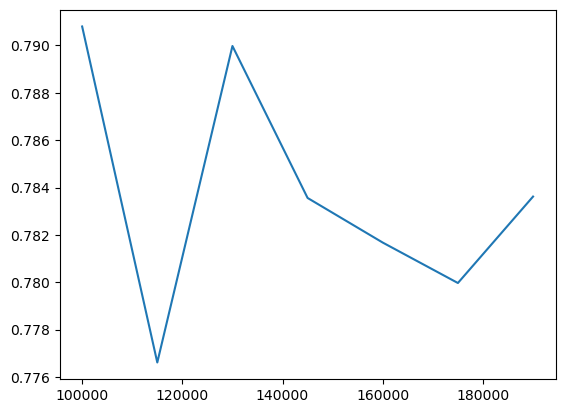

0.7853273749351501


In [35]:
scores_num_words_3 = list(np.array(scores_num_words_3)[:,1])

import matplotlib.pyplot as plt
plt.plot(np.arange(100000,200000,15000),scores_num_words_3)
plt.show()

print(max(scores_num_words_2))

In [ ]:
#Application
scores_embedding_dim=[]
maxlen = 300
num_words= 100000

for embedding_dim in np.arange(50,800,100):
    X_train, X_test, y_train, y_test = preprocess_texte(df=df,maxlen=maxlen,num_words=num_words,embedding_dim = 200)
    model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=num_words,embedding_dim = 200)
    score = model_entraine.evaluate(X_test, y_test, batch_size=128)
    scores_embedding_dim.append(score) 


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 462s 434ms/step - loss: 1.6575 - accuracy: 0.4863 - val_loss: 0.9326 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 456s 429ms/step - loss: 0.7074 - accuracy: 0.7867 - val_loss: 0.7411 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 463s 436ms/step - loss: 0.4075 - accuracy: 0.8762 - val_loss: 0.7630 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9257
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 458s 432ms/step - loss: 0.2481 - accuracy: 0.9257 - val_loss: 0.9057 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 143ms/step - loss: 0.7411 - accuracy: 0.7810


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 429s 402ms/step - loss: 1.7035 - accuracy: 0.4798 - val_loss: 0.9477 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 425s 400ms/step - loss: 0.7201 - accuracy: 0.7854 - val_loss: 0.7562 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 424s 399ms/step - loss: 0.4143 - accuracy: 0.8765 - val_loss: 0.7833 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9256
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 423s 398ms/step - loss: 0.2488 - accuracy: 0.9256 - val_loss: 0.8850 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 17s 125ms/step - loss: 0.7562 - accuracy: 0.7793


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 449s 421ms/step - loss: 1.6364 - accuracy: 0.5007 - val_loss: 0.9298 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 447s 421ms/step - loss: 0.6859 - accuracy: 0.7930 - val_loss: 0.7153 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 450s 423ms/step - loss: 0.3840 - accuracy: 0.8844 - val_loss: 0.7739 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9308
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 455s 428ms/step - loss: 0.2317 - accuracy: 0.9308 - val_loss: 0.8845 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 143ms/step - loss: 0.7153 - accuracy: 0.7882


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 433s 406ms/step - loss: 1.6552 - accuracy: 0.4915 - val_loss: 0.9508 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 433s 407ms/step - loss: 0.7255 - accuracy: 0.7843 - val_loss: 0.7459 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 433s 407ms/step - loss: 0.4202 - accuracy: 0.8741 - val_loss: 0.7722 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9236
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 432s 407ms/step - loss: 0.2545 - accuracy: 0.9236 - val_loss: 0.8450 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 141ms/step - loss: 0.7459 - accuracy: 0.7789


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 454s 426ms/step - loss: 1.6205 - accuracy: 0.5002 - val_loss: 0.9094 - val_accuracy: 0.7198 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 460s 433ms/step - loss: 0.6786 - accuracy: 0.7940 - val_loss: 0.7105 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 465s 438ms/step - loss: 0.3774 - accuracy: 0.8840 - val_loss: 0.7682 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9319
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 2.
1062/1062 [==============================] - 463s 436ms/step - loss: 0.2234 - accuracy: 0.9319 - val_loss: 0.9110 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 4: early stopping
133/133 [==============================] - 19s 141ms/step - loss: 0.7105 - accuracy: 0.7884


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/4
1062/1062 [==============================] - 449s 421ms/step - loss: 1.6344 - accuracy: 0.4978 - val_loss: 0.9422 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 2/4
 572/1062 [===============>..............] - ETA: 3:07 - loss: 0.7478 - accuracy: 0.7755

# Travail à l'aide du texte traduit intégralement en EN

In [64]:
df_EN = load('df_texte_traduit_en.joblib')
df_EN.head()

,prdtypecode,texte_traduit_en
0,10,Olivia: Personalized Notebook / 150 Pages / Do...
1,2280,Journal Des Arts (Le) N° 133 Of 09/28/2001 - A...
2,50,Large Blue Ergonomic Stylus Gamepad Nintendo W...
3,1280,Donald Plush - Europe - Disneyland 2000 (Finge...
4,2705,The War of the Tuques Luc has ideas of grandeu...


### Sur 4 epochs

In [65]:
X_train, X_test, y_train, y_test = preprocess_texte(df,maxlen=500,num_words=10000,embedding_dim = 250,langue='EN')

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

In [67]:
model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=10000,embedding_dim = 250)

Epoch 1/4
1062/1062 [==============================] - 768s 722ms/step - loss: 1.7019 - accuracy: 0.4832 - val_loss: 0.9621 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 2/4
1062/1062 [==============================] - 746s 703ms/step - loss: 0.7985 - accuracy: 0.7598 - val_loss: 0.7777 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 3/4
1062/1062 [==============================] - 749s 705ms/step - loss: 0.6084 - accuracy: 0.8130 - val_loss: 0.7596 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/4
1062/1062 [==============================] - 746s 703ms/step - loss: 0.4970 - accuracy: 0.8458 - val_loss: 0.7735 - val_accuracy: 0.7812 - lr: 0.0010
[0.7914506793022156, 0.7714908123016357]


In [68]:
score = model_entraine.evaluate(X_test, y_test, batch_size=128)
print(score)


133/133 [==============================] - 38s 287ms/step - loss: 0.7735 - accuracy: 0.7812
[0.7734773755073547, 0.7812058329582214]


### Sur 6 epochs

In [72]:
X_train, X_test, y_train, y_test = preprocess_texte(df,maxlen=500,num_words=10000,embedding_dim = 250,langue='EN')

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

In [ ]:
model_entraine = train_model(X_train, X_test,y_train,y_test,num_words=10000,embedding_dim = 250)

Epoch 1/6
 406/1062 [==========>...................] - ETA: 7:26 - loss: 2.4028 - accuracy: 0.2737

# Test d'un autre modèle

In [71]:
df_FR = load('df_texte_traduit_fr.joblib')

X_train, X_test, y_train, y_test = preprocess_texte(df_FR,maxlen=500,num_words=10000,embedding_dim = 250)

num_words=10000
embedding_dim=250

model = Sequential()
model.add(Embedding(num_words, embedding_dim))
model.add(RNN(GRUCell(128), return_sequences=True))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))     
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))     
model.add(Dropout(0.3))
model.add(Dense(56, activation='relu'))     
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(X_train, y_train,
    batch_size = 64,
    epochs=5,
    callbacks=[[reduce_learning_rate, early_stopping]],
    validation_data = [X_test, y_test])

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

C:\Users\Frederic\AppData\Local\Temp\ipykernel_6596\3695007898.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

Epoch 1/5
1062/1062 [==============================] - 789s 741ms/step - loss: 2.0807 - accuracy: 0.3583 - val_loss: 1.3608 - val_accuracy: 0.5626 - lr: 0.0010
Epoch 2/5
1062/1062 [==============================] - 785s 739ms/step - loss: 1.2127 - accuracy: 0.6263 - val_loss: 1.0001 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 3/5
1062/1062 [==============================] - 771s 726ms/step - loss: 0.9247 - accuracy: 0.7234 - val_loss: 0.9038 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 4/5
1062/1062 [==============================] - 769s 724ms/step - loss: 0.7818 - accuracy: 0.7695 - val_loss: 0.8842 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 5/5
1062/1062 [==============================] - 772s 727ms/step - loss: 0.6748 - accuracy: 0.7993 - val_loss: 0.9191 - val_accuracy: 0.7555 - lr: 0.0010
